# Grape diseases and pests classification

**Chi Tran - CMPE 257**

In [1]:
from __future__ import (absolute_import, 
                        division, 
                        print_function, 
                        unicode_literals)

import os
import glob
import time
import numpy as np
import pandas as pd
import math
import seaborn as sns
import random
import shutil
import pylab
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import tensorflow as tf
import h5py
from tensorflow.keras import models, layers, optimizers 
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
from keras.applications import imagenet_utils
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE

# Set random seed for consistency
random.seed(150)
np.random.seed(150)
tf.random.set_seed(150)

# Displays all outputs of a cell 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 6]

print('TensorFlow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)


Using TensorFlow backend.


TensorFlow version: 2.1.0
Keras version: 2.2.4-tf


## Data structure

I will apply an unsupervised machine learning model to recognize and classify the images. Therefore, Keras ImageDataGenerator is the best choice. As mentioned on the website: https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720, my data will be divided into sub-folders that corresponding to image classes under train, validation, and test folders.

<p align='center'>
  ![](https://cdn-images-1.medium.com/max/800/1*HpvpA9pBJXKxaPCl5tKnLg.jpeg)
</p>

In [2]:
# Set up main folders to store original images, binary data, and trained models
root = '.'
data = os.path.join(root, 'img_data')
bin_data= os.path.join(root, 'bin_data')
trained_models = os.path.join(root, 'trained_models')

# Original images
phylloxera_fold = os.path.join(data, 'phylloxera')
mealybug_fold = os.path.join(data, 'mealybug')
b_measles_fold = os.path.join(data, 'black_measles')
b_rot_fold = os.path.join(data, 'black_rot')
leaf_blight_fold = os.path.join(data, 'leaf_blight')
healthy = os.path.join(data, 'healthy')

# Define train, validation, and test folders
train_fold = os.path.join(data, 'train')
val_fold = os.path.join(data, 'validation')
test_fold = os.path.join(data, 'test')

# Create sub-folders for each class in train folder
train_phylloxera = os.path.join(train_fold, 'phylloxera')
train_mealybug = os.path.join(train_fold, 'mealybug')
train_b_measles = os.path.join(train_fold, 'black_measles')
train_b_rot = os.path.join(train_fold, 'black_rot')
train_leaf_blight = os.path.join(train_fold, 'leaf_blight')
train_healthy = os.path.join(train_fold, 'healthy')

# Create sub-folders for each class in validation folder
val_phylloxera = os.path.join(val_fold, 'phylloxera')
val_mealybug = os.path.join(val_fold, 'mealybug')
val_b_measles = os.path.join(val_fold, 'black_measles')
val_b_rot = os.path.join(val_fold, 'black_rot')
val_leaf_blight = os.path.join(val_fold, 'leaf_blight')
val_healthy = os.path.join(val_fold, 'healthy')

# Create sub-folders for each class in test folder
test_phylloxera = os.path.join(test_fold, 'phylloxera')
test_mealybug = os.path.join(test_fold, 'mealybug')
test_b_measles = os.path.join(test_fold, 'black_measles')
test_b_rot = os.path.join(test_fold, 'black_rot')
test_leaf_blight = os.path.join(test_fold, 'leaf_blight')
test_healthy = os.path.join(test_fold, 'healthy')


In [4]:
# Create folders to store original images, binary data, and trained models
os.mkdir(data)
os.mkdir(bin_data)
os.mkdir(trained_models)

# Create train, validation, and test folders
os.mkdir(train_fold)
os.mkdir(val_fold)
os.mkdir(test_fold)

# Create sub-folders for each class inside the train folder
os.mkdir(train_phylloxera)
os.mkdir(train_mealybug)
os.mkdir(train_b_measles)
os.mkdir(train_b_rot)
os.mkdir(train_leaf_blight)
os.mkdir(train_healthy)

# Create sub-folders for each class inside the validation folder
os.mkdir(val_phylloxera)
os.mkdir(val_mealybug)
os.mkdir(val_b_measles)
os.mkdir(val_b_rot)
os.mkdir(val_leaf_blight)
os.mkdir(val_healthy)

# Create sub-folders for each class inside the test folder
os.mkdir(test_phylloxera)
os.mkdir(test_mealybug)
os.mkdir(test_b_measles)
os.mkdir(test_b_rot)
os.mkdir(test_leaf_blight)
os.mkdir(test_healthy)

## Build Dataset from original data

### Collect Images in each class

In [3]:
total_phylloxera = len(os.listdir(phylloxera_fold))
total_mealybug = len(os.listdir(mealybug_fold))
total_b_measles = len(os.listdir(b_measles_fold))
total_b_rot = len(os.listdir(b_rot_fold))
total_leaf_blight = len(os.listdir(leaf_blight_fold))
total_healthy = len(os.listdir(healthy))

total_images = total_phylloxera + total_mealybug + total_b_measles + total_b_rot + total_leaf_blight + total_healthy
                                   
print('Total Images: {}'.format(total_images))
print('There are {} images in phylloxera class'.format(total_phylloxera))
print('There are {} images in mealybug class'.format(total_mealybug))
print('There are {} images in black measles class'.format(total_b_measles))
print('There are {} images in black rot class'.format(total_b_rot))
print('There are {} images in leaf blight class'.format(total_leaf_blight))
print('There are {} images in healthy class'.format(total_healthy))


Total Images: 4796
There are 200 images in phylloxera class
There are 534 images in mealybug class
There are 1383 images in black measles class
There are 1180 images in black rot class
There are 1076 images in leaf blight class
There are 423 images in healthy class


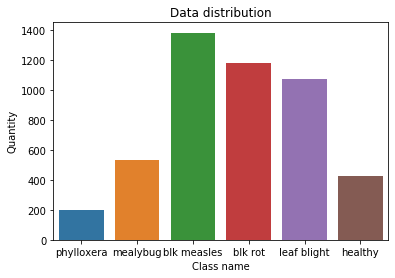

In [5]:
# Show data distribution using bar charts
data_col = pd.DataFrame.from_dict(data={ 'phylloxera': [total_phylloxera],
                                        'mealybug': [total_mealybug],
                                         'blk measles': [total_b_measles],
                                          'blk rot': [total_b_rot],
                                          'leaf blight': [total_leaf_blight],
                                          'healthy': [total_healthy]
                                          } )
sns.barplot(data=data_col);
plt.xlabel('Class name');
plt.ylabel('Quantity');
plt.title('Data distribution');

### Rename Images
The model may not be able to read a file with a very long name, so that all images should be named using a naming convention.

In [6]:
def rename_images(path, image_class):
  """
  Standardize file names.
  @param path - the path to the image directory
  @param image_class - name of the image class, such as black measles or black rot
  """
  for i, image in enumerate(os.listdir(path)):
    name = image_class + str(i) + '.jpg'
    source = os.path.join(path, image)
    dest = os.path.join(path, name)
    os.rename(source, dest)
  print('Finish renaming.')

In [63]:
# Rename images in each folder
rename_images(phylloxera_fold, image_class='phylloxera')
rename_images(mealybug_fold, image_class='mealybug')
rename_images(b_measles_fold, image_class='black_measles')
rename_images(b_rot_fold, image_class='black_rot')
rename_images(leaf_blight_fold, image_class='leaf_blight')
rename_images(healthy, image_class='healthy')


FileExistsError: [WinError 183] Cannot create a file when that file already exists: '.\\data\\black_measles\\black_measles10.jpg' -> '.\\data\\black_measles\\black_measles2.jpg'

### Shuffle and split data into train, validation and test folder

Data will be splited based on the following rule: 80% of data for training and 20% for test. Afterwards, the training set will be divided into 80% training and 20% validation.

In [7]:
def train_test_split_data(data_source, class_name, val_size=0.2, test_size=0.2):
  
  assert class_name in ['phylloxera', 'mealybug', 'black_measles', 'black_rot', 'leaf_blight', 'healthy'], \
    "Class name is invalid!"
  
  train_folder = os.path.join(data_source, 'train', class_name)
  val_folder = os.path.join(data_source, 'validation', class_name)
  test_folder = os.path.join(data_source, 'test', class_name)
  
  assert len(os.listdir(train_folder)) == 0, "Training directory must be empty."
  assert len(os.listdir(val_folder)) == 0, "Validation directory must be empty."
  assert len(os.listdir(test_folder)) == 0, "Test directory must be empty."
  
  path = os.path.join(data_source, class_name)
  total = len(os.listdir(path))
  
  # Shuffle the data
  data = os.listdir(path)
  random.shuffle(data)
  
  # Split train and test data: 80-20
  total_train = math.floor(total*0.8)
  total_test = total - total_train
  
  # Split train-validation data from train data: 80-20
  total_val = math.floor(total_train*0.2)
  total_train = total_train - total_val
  
  # Set data index
  train_dat = data[:total_train]
  val_dat = data[total_train:total_train+total_val]
  test_dat = data[total_train+total_val:]
    
  # Copy training data
  for file in train_dat:
    source = os.path.join(data_source, class_name, file)
    dest = os.path.join(train_folder, file)
    shutil.copyfile(source, dest)
    
  # Copy validation data
  for file in val_dat:
    source = os.path.join(data_source, class_name, file)
    dest = os.path.join(val_folder, file)
    shutil.copyfile(source, dest)
    
  # Copy test data
  for file in test_dat:
    source = os.path.join(data_source, class_name, file)
    dest = os.path.join(test_folder, file)
    shutil.copyfile(source, dest)

### Split data

In [9]:
for class_name in ['phylloxera', 'mealybug', 'black_measles', 'black_rot', 'leaf_blight', 'healthy']:
  train_test_split_data(data, class_name)

Checking data allocation after spliting

In [11]:
# Checking data
total_train_phylloxera = len(os.listdir(train_phylloxera))
total_train_mealybug = len(os.listdir(train_mealybug))
total_train_b_measles = len(os.listdir(train_b_measles))
total_train_b_rot = len(os.listdir(train_b_rot))
total_train_leaf_blight = len(os.listdir(train_leaf_blight))
total_train_healthy = len(os.listdir(train_healthy))

total_valid_phylloxera = len(os.listdir(val_phylloxera))
total_valid_mealybug = len(os.listdir(val_mealybug))
total_valid_b_measles = len(os.listdir(val_b_measles))
total_valid_b_rot = len(os.listdir(val_b_rot))
total_valid_leaf_blight = len(os.listdir(val_leaf_blight))
total_valid_healthy = len(os.listdir(val_healthy))

total_test_phylloxera = len(os.listdir(test_phylloxera))
total_test_mealybug = len(os.listdir(test_mealybug))
total_test_b_measles = len(os.listdir(test_b_measles))
total_test_b_rot = len(os.listdir(test_b_rot))
total_test_leaf_blight = len(os.listdir(test_leaf_blight))
total_test_healthy = len(os.listdir(test_healthy))

total_train = total_train_b_measles + total_train_b_rot + \
                total_train_leaf_blight + total_train_healthy + total_train_phylloxera + total_train_mealybug
total_valid = total_valid_b_measles + total_valid_b_rot + \
              total_valid_leaf_blight + total_valid_healthy + total_valid_phylloxera + total_valid_mealybug
total_test = total_test_b_measles + total_test_b_rot + \
              total_test_leaf_blight + total_test_healthy + total_test_phylloxera + total_test_mealybug

def check_dist(total, phylloxera, mealybug, black_measles, black_rot, leaf_blight, healthy):
  print('Phylloxera class occupies: {:.2f}%'.format((phylloxera / total)*100.0))
  print('Mealybug class occupies: {:.2f}%'.format((mealybug / total)*100.0))
  print('Black measles class occupies: {:.2f}%'.format((black_measles/total)*100.0))
  print('Black rot class occupies: {:.2f}%'.format((black_rot / total)*100))
  print('Left blight class occupies: {:.2f}%'.format((leaf_blight / total)*100.0))
  print('Healthy class occupies: {:.2f}%'.format((healthy / total)*100.0))
  print()
  
print('Total images:', total_train + total_valid + total_test)
print('Total phylloxera:', total_train_phylloxera + total_valid_phylloxera + total_test_phylloxera)
print('Total mealybug:', total_train_mealybug + total_valid_mealybug + total_test_mealybug)
print('Total black measles:', total_train_b_measles + total_valid_b_measles + total_test_b_measles)
print('Total black rot:', total_train_b_rot + total_valid_b_rot + total_test_b_rot)
print('Total leaf blight:', total_train_leaf_blight + total_valid_leaf_blight + total_test_leaf_blight)
print('Total healthy:', total_train_healthy + total_valid_healthy + total_test_healthy)
print()

print('Total of training phylloxera images:', total_train_phylloxera)
print('Total of training mealybug images:', total_train_mealybug)
print('Total of training black measles images:', total_train_b_measles)
print('Total of training black rot images:', total_train_b_rot)
print('Total of training leaf blight images:', total_train_leaf_blight)
print('Total of training healthy images:', total_train_healthy)
print()

print('Total of validation phylloxera images:', total_valid_phylloxera)
print('Total of validation mealybug images:', total_valid_mealybug)
print('Total of validation black measles images:', total_valid_b_measles)
print('Total of validation black rot images:', total_valid_b_rot)
print('Total of validation leaf blight images:', total_valid_leaf_blight)
print('Total of validation healthy images:', total_valid_healthy)
print()

print('Total of test phylloxera images:', total_test_phylloxera)
print('Total of test mealybug images:', total_test_mealybug)
print('Total of test black measles images:', total_test_b_measles)
print('Total of test black rot images:', total_test_b_rot)
print('Total of test leaf blight images:', total_test_leaf_blight)
print('Total of test healthy images:', total_test_healthy)
print()

print('Training distribution')
check_dist(total_train, total_train_b_measles, total_train_b_rot,
                    total_train_leaf_blight, total_train_healthy, total_train_phylloxera, total_train_mealybug)
print('Validation distribution')
check_dist(total_valid, total_valid_b_measles, total_valid_b_rot,
                    total_valid_leaf_blight, total_valid_healthy, total_valid_phylloxera, total_valid_mealybug)
print('Test distribution')
check_dist(total_test, total_test_b_measles, total_test_b_rot,
                    total_test_leaf_blight, total_test_healthy, total_test_phylloxera, total_test_mealybug)


Total images: 4796
Total phylloxera: 200
Total mealybug: 534
Total black measles: 1383
Total black rot: 1180
Total leaf blight: 1076
Total healthy: 423

Total of training phylloxera images: 128
Total of training mealybug images: 343
Total of training black measles images: 886
Total of training black rot images: 756
Total of training leaf blight images: 689
Total of training healthy images: 272

Total of validation phylloxera images: 32
Total of validation mealybug images: 85
Total of validation black measles images: 221
Total of validation black rot images: 188
Total of validation leaf blight images: 172
Total of validation healthy images: 67

Total of test phylloxera images: 40
Total of test mealybug images: 106
Total of test black measles images: 276
Total of test black rot images: 236
Total of test leaf blight images: 215
Total of test healthy images: 84

Training distribution
Phylloxera class occupies: 28.82%
Mealybug class occupies: 24.59%
Black measles class occupies: 22.41%
Blac

## Data Analysis

### Observe Data Images

In [4]:
def read_data(path, size):
  img = image.load_img(path, target_size=size)
  img = image.img_to_array(img)
  return img

C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


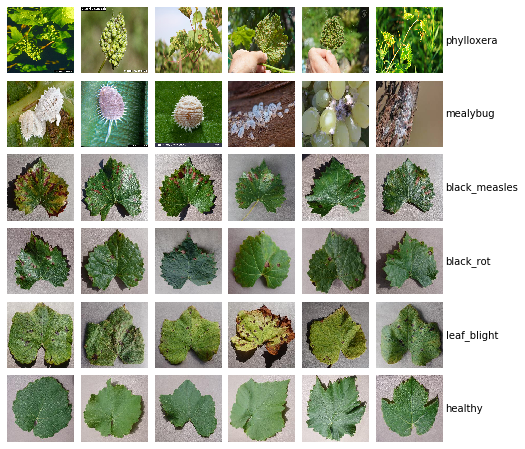

In [5]:
CATE = ['phylloxera', 'mealybug', 'black_measles', 'black_rot', 'leaf_blight', 'healthy']
NUM_CATE = len(CATE)
img_height, img_width = 256, 256

# Create image grid
figure = plt.figure(num=1, figsize=(8,8))
grid = ImageGrid(figure, 111, nrows_ncols=(NUM_CATE,NUM_CATE),
                 axes_pad=0.1) 

# Plot each image into a square
i = 0
for cate in CATE:
  for j in range(6):
    ax = grid[i]
    path = os.path.join(data, cate)
    pic = cate + str(j) + '.jpg'
    im = read_data(os.path.join(path, pic), size=(img_height, img_width))
    ax.imshow(im/255., interpolation='nearest', aspect='auto')
    ax.axis('off')
    if i % NUM_CATE == NUM_CATE - 1:
      ax.text(x=img_height*1.05, y=img_height//2, s=cate, verticalalignment='center')
    i += 1

figure.show();

## Load images into numpy arrays

In [11]:
# Read all phylloxera images into numpy array
phylloxera_numpy = [read_data(os.path.join(train_phylloxera, img),\
               (256, 256)) for img in os.listdir(train_phylloxera)]

# Read all mealybug images into numpy array
mealybug_numpy = [read_data(os.path.join(train_mealybug, img),\
               (256, 256)) for img in os.listdir(train_mealybug)]


# Read all black measles images into numpy array
b_measles_numpy = [read_data(os.path.join(train_b_measles, img), \
                    (256, 256)) for img in os.listdir(train_b_measles)]

# Read all black rot images into numpy array
b_rot_numpy = [read_data(os.path.join(train_b_rot, img), \
                 (256, 256)) for img in os.listdir(train_b_rot)]

# Read all leaf blight images into numpy array
leaf_blight_numpy = [read_data(os.path.join(train_leaf_blight, img), \
                   (256, 256)) for img in os.listdir(train_leaf_blight)]

# Read all healthy images into numpy array
healthy_numpy = [read_data(os.path.join(train_healthy, img),\
               (256, 256)) for img in os.listdir(train_healthy)]


# Save numpy arrays into a folder
np.save(os.path.join(bin_data, 'phylloxera.npy'), arr=phylloxera_numpy)
np.save(os.path.join(bin_data, 'mealybug.npy'), arr=mealybug_numpy)
np.save(os.path.join(bin_data, 'black_measles.npy'), arr=b_measles_numpy)
np.save(os.path.join(bin_data, 'black_rot.npy'), arr=b_rot_numpy)
np.save(os.path.join(bin_data, 'leaf_blight.npy'), arr=leaf_blight_numpy)
np.save(os.path.join(bin_data, 'healthy.npy'), arr=healthy_numpy)


C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [12]:
# Load numpy arrays from the folder
phylloxera_numpy = np.load(os.path.join(bin_data, 'phylloxera.npy'))
mealybug_numpy = np.load(os.path.join(bin_data, 'mealybug.npy'))
b_measles_numpy = np.load(os.path.join(bin_data, 'black_measles.npy'))
b_rot_numpy = np.load(os.path.join(bin_data, 'black_rot.npy'))
leaf_blight_numpy = np.load(os.path.join(bin_data, 'leaf_blight.npy'))
healthy_numpy = np.load(os.path.join(bin_data, 'healthy.npy'))

In [13]:
# Reshape numpy arrays into sizes of 256x256x3 as input data
phylloxera_numpy = phylloxera_numpy.reshape(128, 256*256*3)
mealybug_numpy = mealybug_numpy.reshape(343, 256*256*3)
b_measles_numpy = b_measles_numpy.reshape(886, 256*256*3)
b_rot_numpy = b_rot_numpy.reshape(756, 256*256*3)
leaf_blight_numpy = leaf_blight_numpy.reshape(689, 256*256*3)
healthy_numpy = healthy_numpy.reshape(272, 256*256*3)

### Visualize data

In [10]:
def pca(X=np.array([]), num_dimensions=60):
  """
  Runs PCA on an array X to reduce its dimensonality to 
  num_dimensions dimensions.
  
  """
  print('Running PCA ...')
  mean_vector = np.mean(a=X, axis=0)
  X_cov = (X-mean_vec).T.dot(X-mean_vec) / (X.shape[0]-1)
  eig_vals, eig_vectors = np.linalg.eig(X_cov.T)
  idx = np.argsort(np.abs(eig_vals))[::-1]
  eig_vectors = eig_vectors[:, idx]
  Y = np.dot(X, eig_vectors[:, 0:num_dimensions])
  return Y

def plot_scatter(x, class_name):
  """
  Function to create a scatter plot for visualization of data
  along with respective colors/labels.
 
  """
  no_class = len(np.unique(class_name))
  color_palette = np.array(sns.color_palette('Set2', no_class))
  f = plt.figure(figsize=(15,15))
  ax = plt.subplot(aspect='equal')
  for i, pic_label in enumerate(np.unique(class_name)):
    idx = np.where(class_name == pic_label)
    ax.scatter(x[idx,0], x[idx,1], s=30, alpha=0.6, 
                    c=[color_palette[i]], label=pic_label)
  ax.legend(loc='best', fontsize='medium')
  ax.axis('off')
  ax.axis('tight')
  plt.title('Visualization of grape diseases and pests in 2D')

In [15]:
# Create data labels for all classes in 1D
phylloxera_label = np.full(phylloxera_numpy.shape[0], 'phylloxera')
mealybug_label = np.full(mealybug_numpy.shape[0], 'mealybug')
b_measles_label = np.full(b_measles_numpy.shape[0], 'black_measles')
b_rot_label = np.full(b_rot_numpy.shape[0], 'black_rot')
leaf_blight_label = np.full(leaf_blight_numpy.shape[0], 'leaf_blight')
healthy_label = np.full(healthy_numpy.shape[0], 'healthy')

labels = (phylloxera_label, mealybug_label, b_measles_label, b_rot_label, leaf_blight_label, healthy_label)
labels = np.hstack(labels) 

In [17]:
# Create a stack of numpy arrays 
tuple_data = (phylloxera_numpy, mealybug_numpy, b_measles_numpy, b_rot_numpy, leaf_blight_numpy, healthy_numpy)

# normalize tuple data
nomalized_data = np.vstack(tup=tuple_data)/255. 

In [19]:
# Run PCA on nomalized data
start_time = time.time()
pca = PCA(n_components=60)
nomalized_data_pca = pca.fit_transform(nomalized_data)
end_time = time.time()

print('This process took {:.2f} seconds.'.format(end_time-start_time))

This process took 113.86 seconds.


In [21]:
# Run t-SNE on data
start_time = time.time()
tsne = TSNE(n_components=2)
nomalized_data_tsne = tsne.fit_transform(nomalized_data_pca)
end_time = time.time()

print('This process took {:.2f} seconds'.format(end_time-start_time))

This process took 50.40 seconds


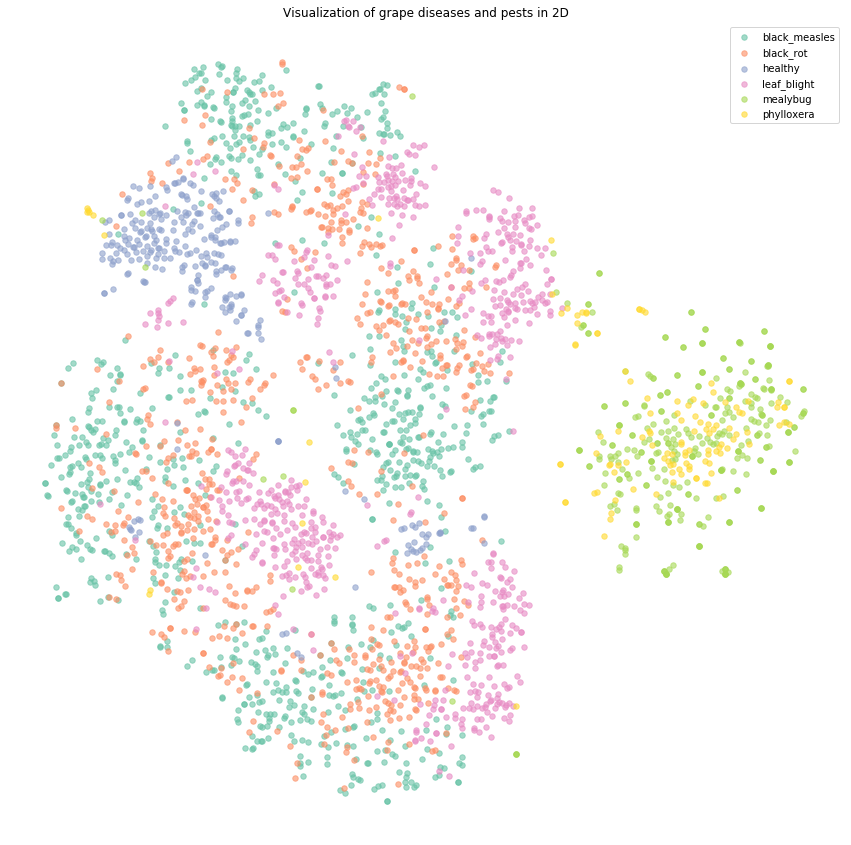

In [25]:
# Visualize data
plot_scatter(nomalized_data_tsne, labels);

## Training data

### Libraries

In [7]:
def draw_acc_loss(points, factor=0.9):
  
  drawed_points = []
  for point in points:
    if drawed_points:
      prev = drawed_points[-1]
      drawed_points.append(prev * factor + point * (1 - factor))
    else:
      drawed_points.append(point)
  return drawed_points

def plot_data(history_data, smooth=False):

  accuracy = history.history['acc']
  validation_acc = history.history['val_acc']
  loss = history.history['loss']
  validation_loss = history.history['val_loss']

  epochs = range(1, len(accuracy)+1)
  
  if smooth == True:
    accuracy = draw_acc_loss(accuracy)
    validation_acc = draw_acc_loss(validation_acc)
    loss = draw_acc_loss(loss)
    validation_loss = draw_acc_loss(validation_loss)

  plt.plot(epochs, accuracy, 'g', label='Training accuracy')
  plt.plot(epochs, validation_acc,'r', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'g', label='Training loss')
  plt.plot(epochs, validation_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()
  
def collect_metrics(model, generator, steps, class_names=[]):
  """
  Print out confusion matrix and classification report.
  """
  class_names = ['black_measles', 'black_rot', 'healthy', 'leaf_blight', 'mealybug', 'phylloxera']
  abbr = ['BM', 'BR', 'H', 'LB', 'M', 'P']
  
  # Generate predictions 
  y_pred = model.predict_generator(generator=generator, steps=steps)
  y_pred = np.argmax(a=y_pred, axis=1)
  
  # Generate confusion matrix
  con_matrix = confusion_matrix(y_true=generator.classes, y_pred=y_pred)
  fig, ax = plt.subplots(1)
  ax = sns.heatmap(con_matrix, ax=ax, cmap=plt.cm.YlOrRd, annot=True, fmt='g')
  ax.set_xticklabels(abbr)
  ax.set_yticklabels(abbr)
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted Class')
  plt.ylabel('Real Class')
  plt.show()
  
  # Generate classification report
  print('Classification Report')
  print(classification_report(y_true=generator.classes, y_pred=y_pred, 
                              target_names=class_names))

### Set up hyper-parameters

In [12]:
image_height, image_width = 256, 256
batch_size = 30
epochs = 35

print('Total number of training data:', total_train)
print('Total number of validation data:', total_valid)
print('Total number of test data:', total_test)

Total number of training data: 3074
Total number of validation data: 765
Total number of test data: 957


### Training from Scratch

In [22]:
model = models.Sequential([
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', \
                  input_shape=(image_height, image_width, 3)),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(units=512, activation='relu'),
    layers.Dense(units=6, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       1

In [23]:
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=0.001),
              metrics=['acc'])

Training data using Keras ImageDataGenerator. Refer to the source on the website: https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720

In [13]:
# Rescale data
training_datagenerator = ImageDataGenerator(rescale=1./255)
test_datagenerator = ImageDataGenerator(rescale=1./255)

training_gen = training_datagenerator.flow_from_directory(
                    train_fold,
                    target_size=(image_height, image_width),
                    color_mode='rgb',
                    batch_size=batch_size,
                    class_mode='categorical',
                    shuffle=True, 
                    seed=30)

valid_gen = test_datagenerator.flow_from_directory(
                          val_fold,
                          target_size=(image_height, image_width),
                          color_mode='rgb',
                          batch_size=batch_size,
                          class_mode='categorical')

Found 3074 images belonging to 6 classes.
Found 765 images belonging to 6 classes.


In [13]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from datetime import datetime
from packaging import version

import tensorflow as tf
from tensorflow import keras

# Define the Keras TensorBoard callback.
logdir="logs\\fit\\" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, profile_batch=0)
    

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [26]:
#Scratch training
history = model.fit(
            training_gen,
            steps_per_epoch=total_train // batch_size,
            epochs=epochs,
            validation_data=valid_gen,
            validation_steps=total_valid // batch_size,
            callbacks=[tensorboard_callback])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 102 steps, validate for 25 steps
Epoch 1/35
 47/102 [============>.................] - ETA: 3:04 - loss: 1.3609 - acc: 0.4570

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 329s 3s/step - loss: 0.9861 - acc: 0.6041 - val_loss: 0.5017 - val_acc: 0.8093
Epoch 2/35
 58/102 [================>.............] - ETA: 2:00 - loss: 0.3825 - acc: 0.8451

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 301s 3s/step - loss: 0.3608 - acc: 0.8581 - val_loss: 0.2877 - val_acc: 0.8933
Epoch 3/35
 50/102 [=============>................] - ETA: 2:20 - loss: 0.2528 - acc: 0.9003

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 297s 3s/step - loss: 0.2293 - acc: 0.9116 - val_loss: 0.2857 - val_acc: 0.9160
Epoch 4/35
 23/102 [=====>........................] - ETA: 3:49 - loss: 0.3331 - acc: 0.8725

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 314s 3s/step - loss: 0.2187 - acc: 0.9182 - val_loss: 0.2300 - val_acc: 0.9187
Epoch 5/35


C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 304s 3s/step - loss: 0.1307 - acc: 0.9527 - val_loss: 0.2003 - val_acc: 0.9507
Epoch 6/35
 37/102 [=========>....................] - ETA: 3:00 - loss: 0.0842 - acc: 0.9730

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 303s 3s/step - loss: 0.0731 - acc: 0.9714 - val_loss: 0.1515 - val_acc: 0.9600
Epoch 7/35
 20/102 [====>.........................] - ETA: 3:44 - loss: 0.0349 - acc: 0.9850

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 301s 3s/step - loss: 0.0863 - acc: 0.9724 - val_loss: 0.1406 - val_acc: 0.9573
Epoch 8/35
 84/102 [=======================>......] - ETA: 49s - loss: 0.0386 - acc: 0.9893

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 303s 3s/step - loss: 0.0377 - acc: 0.9898 - val_loss: 0.1518 - val_acc: 0.9533
Epoch 9/35
 85/102 [========================>.....] - ETA: 45s - loss: 0.0261 - acc: 0.9917

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 295s 3s/step - loss: 0.0251 - acc: 0.9924 - val_loss: 0.1756 - val_acc: 0.9627
Epoch 10/35
 52/102 [==============>...............] - ETA: 2:22 - loss: 0.0162 - acc: 0.9949

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 311s 3s/step - loss: 0.0257 - acc: 0.9918 - val_loss: 0.1335 - val_acc: 0.9613
Epoch 11/35
 86/102 [========================>.....] - ETA: 44s - loss: 0.0443 - acc: 0.9863

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 309s 3s/step - loss: 0.0439 - acc: 0.9859 - val_loss: 0.1632 - val_acc: 0.9640
Epoch 12/35
 13/102 [==>...........................] - ETA: 4:11 - loss: 0.0575 - acc: 0.9872

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 311s 3s/step - loss: 0.0381 - acc: 0.9869 - val_loss: 0.1249 - val_acc: 0.9600
Epoch 13/35
 88/102 [========================>.....] - ETA: 37s - loss: 0.0562 - acc: 0.9836

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 299s 3s/step - loss: 0.0644 - acc: 0.9816 - val_loss: 0.1364 - val_acc: 0.9613
Epoch 14/35
 84/102 [=======================>......] - ETA: 49s - loss: 0.0428 - acc: 0.9877

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 300s 3s/step - loss: 0.0567 - acc: 0.9826 - val_loss: 0.2809 - val_acc: 0.9160
Epoch 15/35
 14/102 [===>..........................] - ETA: 3:53 - loss: 0.0561 - acc: 0.9802

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 301s 3s/step - loss: 0.0296 - acc: 0.9892 - val_loss: 0.0944 - val_acc: 0.9773
Epoch 16/35
 65/102 [==================>...........] - ETA: 1:43 - loss: 0.0091 - acc: 0.9969

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 305s 3s/step - loss: 0.0062 - acc: 0.9980 - val_loss: 0.1390 - val_acc: 0.9747
Epoch 17/35


C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 300s 3s/step - loss: 4.7594e-04 - acc: 1.0000 - val_loss: 0.1464 - val_acc: 0.9747
Epoch 18/35
 87/102 [========================>.....] - ETA: 41s - loss: 1.5807e-04 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 306s 3s/step - loss: 1.5262e-04 - acc: 1.0000 - val_loss: 0.1473 - val_acc: 0.9747
Epoch 19/35
 25/102 [======>.......................] - ETA: 3:23 - loss: 1.3216e-04 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 298s 3s/step - loss: 1.0322e-04 - acc: 1.0000 - val_loss: 0.1462 - val_acc: 0.9747
Epoch 20/35
  6/102 [>.............................] - ETA: 4:26 - loss: 8.8098e-05 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 305s 3s/step - loss: 8.1580e-05 - acc: 1.0000 - val_loss: 0.1529 - val_acc: 0.9747
Epoch 21/35
 78/102 [=====================>........] - ETA: 1:05 - loss: 7.2500e-05 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 299s 3s/step - loss: 6.4587e-05 - acc: 1.0000 - val_loss: 0.1556 - val_acc: 0.9760
Epoch 22/35
 87/102 [========================>.....] - ETA: 41s - loss: 4.6612e-05 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 301s 3s/step - loss: 5.2518e-05 - acc: 1.0000 - val_loss: 0.1623 - val_acc: 0.9760
Epoch 23/35
 78/102 [=====================>........] - ETA: 1:08 - loss: 4.4120e-05 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 312s 3s/step - loss: 4.1995e-05 - acc: 1.0000 - val_loss: 0.1612 - val_acc: 0.9760
Epoch 24/35
 74/102 [====================>.........] - ETA: 1:16 - loss: 3.4177e-05 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 303s 3s/step - loss: 3.6304e-05 - acc: 1.0000 - val_loss: 0.1661 - val_acc: 0.9760
Epoch 25/35
 79/102 [======================>.......] - ETA: 1:02 - loss: 2.9725e-05 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 300s 3s/step - loss: 2.8386e-05 - acc: 1.0000 - val_loss: 0.1680 - val_acc: 0.9760
Epoch 26/35
 48/102 [=============>................] - ETA: 2:24 - loss: 1.7674e-05 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 299s 3s/step - loss: 2.5029e-05 - acc: 1.0000 - val_loss: 0.1658 - val_acc: 0.9747
Epoch 27/35
 91/102 [=========================>....] - ETA: 30s - loss: 2.1073e-05 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 305s 3s/step - loss: 1.9977e-05 - acc: 1.0000 - val_loss: 0.1711 - val_acc: 0.9760
Epoch 28/35
 71/102 [===================>..........] - ETA: 1:24 - loss: 1.8256e-05 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 303s 3s/step - loss: 1.7505e-05 - acc: 1.0000 - val_loss: 0.1745 - val_acc: 0.9760
Epoch 29/35


C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 309s 3s/step - loss: 1.5025e-05 - acc: 1.0000 - val_loss: 0.1750 - val_acc: 0.9747
Epoch 30/35
 79/102 [======================>.......] - ETA: 1:04 - loss: 1.3682e-05 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 308s 3s/step - loss: 1.2918e-05 - acc: 1.0000 - val_loss: 0.1719 - val_acc: 0.9747
Epoch 31/35


C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 307s 3s/step - loss: 1.1492e-05 - acc: 1.0000 - val_loss: 0.1729 - val_acc: 0.9747
Epoch 32/35
 89/102 [=========================>....] - ETA: 37s - loss: 1.0149e-05 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 317s 3s/step - loss: 1.0205e-05 - acc: 1.0000 - val_loss: 0.1759 - val_acc: 0.9747
Epoch 33/35
 80/102 [======================>.......] - ETA: 1:03 - loss: 8.8262e-06 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 318s 3s/step - loss: 9.0503e-06 - acc: 1.0000 - val_loss: 0.1745 - val_acc: 0.9747
Epoch 34/35
 60/102 [================>.............] - ETA: 1:59 - loss: 8.0426e-06 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 312s 3s/step - loss: 8.1389e-06 - acc: 1.0000 - val_loss: 0.1798 - val_acc: 0.9747
Epoch 35/35
 36/102 [=========>....................] - ETA: 3:09 - loss: 6.4989e-06 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 319s 3s/step - loss: 7.1476e-06 - acc: 1.0000 - val_loss: 0.1811 - val_acc: 0.9747


In [50]:
# Save the trained model into the pre-defined folder
model.save(os.path.join(trained_models, 'diseasepest-scratch.h5'))

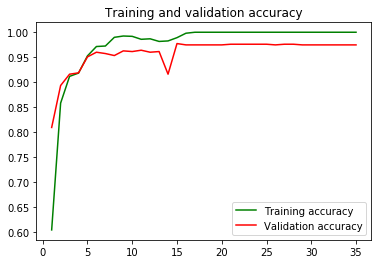

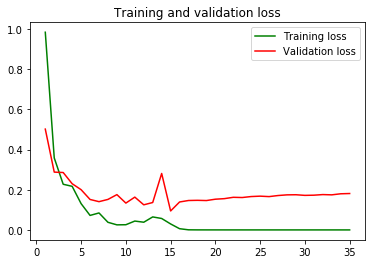

In [36]:
plot_data(history)

In [31]:
# Create a new validation generator for evaluation
valid_test_gen = test_datagenerator.flow_from_directory(
                val_fold,
                target_size=(img_height, img_width),
                color_mode='rgb',
                batch_size=1,
                class_mode='categorical',
                shuffle=False)

Found 765 images belonging to 6 classes.


In [32]:
# Observe all 6 classes
valid_test_gen.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Format of confusion matrix:

|  | Prediction |  |  |  |  |
| - | - | - | - | - | - |
| **True** | black_measles | black_rot | healthy | leaf_blight | mealybug | phylloxera | 
| black_measles | 
| black_rot | 
| healthy | 
| leaf_blight |
| mealybug |
| phylloxera | 

Instructions for updating:
Please use Model.predict, which supports generators.


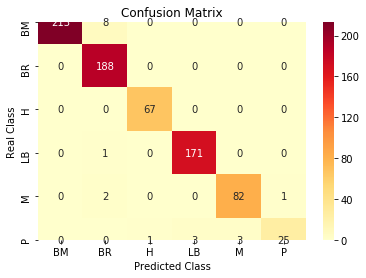

Classification Report
               precision    recall  f1-score   support

black_measles       1.00      0.96      0.98       221
    black_rot       0.94      1.00      0.97       188
      healthy       0.99      1.00      0.99        67
  leaf_blight       0.98      0.99      0.99       172
     mealybug       0.96      0.96      0.96        85
   phylloxera       0.96      0.78      0.86        32

     accuracy                           0.98       765
    macro avg       0.97      0.95      0.96       765
 weighted avg       0.98      0.98      0.97       765



In [33]:
# Load the trained model from the folder
model = load_model(filepath=os.path.join(trained_models, 'diseasepest-scratch.h5'))

# Display confusion matrix and classification report
collect_metrics(model, generator=valid_test_gen, steps=total_valid)

### Transfer Learning

In [26]:
# Import VGG16
from tensorflow.keras.applications import VGG16

conv_base = VGG16(include_top=False,
                  weights='imagenet',
                  input_shape=(image_height, image_width, 3))

In [27]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [28]:
# Add more layers into the original VGG16 model
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(units=6, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 1542      
Total params: 23,105,094
Trainable params: 23,105,094
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Freeze convolutional base
print('Trainable weights before freezing:', len(model.trainable_weights))
conv_base.trainable = False
print('Trainable weights after freezing:', len(model.trainable_weights))

Trainable weights before freezing: 30
Trainable weights after freezing: 4


In [14]:
# Generate training data using data augmentation
training_datageneration = ImageDataGenerator(
                  rescale=1./255,
                  rotation_range=45,
                  width_shift_range=0.1,
                  height_shift_range=0.1,
                  shear_range=0.1,
                  zoom_range=0.1,
                  horizontal_flip=True,
                  vertical_flip=True)

# Rescale validation data
test_datageneration = ImageDataGenerator(rescale=1./255)

training_gen = training_datageneration.flow_from_directory(
                    train_fold,
                    target_size=(image_height, image_width),
                    color_mode='rgb',
                    batch_size=batch_size,
                    class_mode='categorical',
                    shuffle=True, 
                    seed=50)

valid_gen = test_datageneration.flow_from_directory(
                          val_fold,
                          target_size=(image_height, image_width),
                          color_mode='rgb',
                          batch_size=batch_size,
                          class_mode='categorical')

model.compile(optimizer=optimizers.Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['acc'])

Found 3074 images belonging to 6 classes.
Found 765 images belonging to 6 classes.


In [31]:
# Train VGG16 model
history = model.fit(
            training_gen,
            steps_per_epoch=total_train // batch_size,
            epochs=epochs,
            validation_data=valid_gen,
            validation_steps=total_valid // batch_size,
            callbacks=[tensorboard_callback]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 102 steps, validate for 25 steps
Epoch 1/35
 59/102 [================>.............] - ETA: 5:19 - loss: 1.4981 - acc: 0.6123

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 954s 9s/step - loss: 1.0862 - acc: 0.6968 - val_loss: 0.2938 - val_acc: 0.9067
Epoch 2/35
 81/102 [======================>.......] - ETA: 2:39 - loss: 0.4160 - acc: 0.8372

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 964s 9s/step - loss: 0.4114 - acc: 0.8377 - val_loss: 0.2224 - val_acc: 0.9227
Epoch 3/35
 22/102 [=====>........................] - ETA: 10:16 - loss: 0.3698 - acc: 0.8515

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 963s 9s/step - loss: 0.3756 - acc: 0.8492 - val_loss: 0.2311 - val_acc: 0.9067
Epoch 4/35
 75/102 [=====================>........] - ETA: 3:49 - loss: 0.3518 - acc: 0.8591

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1102s 11s/step - loss: 0.3589 - acc: 0.8538 - val_loss: 0.2055 - val_acc: 0.9253
Epoch 5/35
  5/102 [>.............................] - ETA: 14:35 - loss: 0.4302 - acc: 0.8667

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1140s 11s/step - loss: 0.3652 - acc: 0.8610 - val_loss: 0.1726 - val_acc: 0.9373
Epoch 6/35
 62/102 [=================>............] - ETA: 5:31 - loss: 0.3586 - acc: 0.8492

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1035s 10s/step - loss: 0.3654 - acc: 0.8518 - val_loss: 0.1823 - val_acc: 0.9280
Epoch 7/35


C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 980s 10s/step - loss: 0.3340 - acc: 0.8637 - val_loss: 0.1610 - val_acc: 0.9387
Epoch 8/35
 65/102 [==================>...........] - ETA: 4:42 - loss: 0.3106 - acc: 0.8749

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 958s 9s/step - loss: 0.3044 - acc: 0.8781 - val_loss: 0.1386 - val_acc: 0.9533
Epoch 9/35
 54/102 [==============>...............] - ETA: 6:06 - loss: 0.3142 - acc: 0.8722

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 966s 9s/step - loss: 0.3092 - acc: 0.8735 - val_loss: 0.1771 - val_acc: 0.9253
Epoch 10/35
 68/102 [===================>..........] - ETA: 4:22 - loss: 0.2882 - acc: 0.8858

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 969s 9s/step - loss: 0.2909 - acc: 0.8847 - val_loss: 0.1498 - val_acc: 0.9453
Epoch 11/35
 76/102 [=====================>........] - ETA: 3:15 - loss: 0.2732 - acc: 0.8936

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 956s 9s/step - loss: 0.2658 - acc: 0.8955 - val_loss: 0.1304 - val_acc: 0.9493
Epoch 12/35
 27/102 [======>.......................] - ETA: 9:30 - loss: 0.2529 - acc: 0.8926

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 956s 9s/step - loss: 0.2632 - acc: 0.8939 - val_loss: 0.1148 - val_acc: 0.9573
Epoch 13/35
 13/102 [==>...........................] - ETA: 11:32 - loss: 0.3227 - acc: 0.8692

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 938s 9s/step - loss: 0.2757 - acc: 0.8853 - val_loss: 0.1406 - val_acc: 0.9413
Epoch 14/35
 65/102 [==================>...........] - ETA: 4:31 - loss: 0.2872 - acc: 0.8909

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 933s 9s/step - loss: 0.2828 - acc: 0.8939 - val_loss: 0.1106 - val_acc: 0.9653
Epoch 15/35
 51/102 [==============>...............] - ETA: 6:14 - loss: 0.3037 - acc: 0.8712

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 948s 9s/step - loss: 0.2716 - acc: 0.8929 - val_loss: 0.1068 - val_acc: 0.9600
Epoch 16/35
 62/102 [=================>............] - ETA: 4:58 - loss: 0.2398 - acc: 0.9065

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 942s 9s/step - loss: 0.2377 - acc: 0.9093 - val_loss: 0.1073 - val_acc: 0.9640
Epoch 17/35
 43/102 [===========>..................] - ETA: 7:24 - loss: 0.2702 - acc: 0.8876

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 948s 9s/step - loss: 0.2450 - acc: 0.9024 - val_loss: 0.1012 - val_acc: 0.9587
Epoch 18/35
 45/102 [============>.................] - ETA: 7:14 - loss: 0.2430 - acc: 0.9022

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 949s 9s/step - loss: 0.2508 - acc: 0.9044 - val_loss: 0.1047 - val_acc: 0.9613
Epoch 19/35
 84/102 [=======================>......] - ETA: 2:13 - loss: 0.2410 - acc: 0.9077

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 937s 9s/step - loss: 0.2422 - acc: 0.9074 - val_loss: 0.1037 - val_acc: 0.9627
Epoch 20/35
 58/102 [================>.............] - ETA: 5:27 - loss: 0.2570 - acc: 0.9089

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 946s 9s/step - loss: 0.2609 - acc: 0.9044 - val_loss: 0.1241 - val_acc: 0.9600
Epoch 21/35
 50/102 [=============>................] - ETA: 6:29 - loss: 0.2596 - acc: 0.8848

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 945s 9s/step - loss: 0.2480 - acc: 0.8991 - val_loss: 0.1109 - val_acc: 0.9573
Epoch 22/35
 74/102 [====================>.........] - ETA: 3:29 - loss: 0.2770 - acc: 0.9047

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 945s 9s/step - loss: 0.2617 - acc: 0.9103 - val_loss: 0.1147 - val_acc: 0.9573
Epoch 23/35
 54/102 [==============>...............] - ETA: 6:04 - loss: 0.2689 - acc: 0.9037

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 963s 9s/step - loss: 0.2631 - acc: 0.9044 - val_loss: 0.1154 - val_acc: 0.9627
Epoch 24/35
 22/102 [=====>........................] - ETA: 10:15 - loss: 0.2403 - acc: 0.9015

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 984s 10s/step - loss: 0.2478 - acc: 0.9074 - val_loss: 0.0921 - val_acc: 0.9667
Epoch 25/35
 79/102 [======================>.......] - ETA: 2:55 - loss: 0.2500 - acc: 0.9027

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1000s 10s/step - loss: 0.2478 - acc: 0.9021 - val_loss: 0.1067 - val_acc: 0.9613
Epoch 26/35
 67/102 [==================>...........] - ETA: 4:32 - loss: 0.2806 - acc: 0.8877

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 985s 10s/step - loss: 0.2774 - acc: 0.8883 - val_loss: 0.2507 - val_acc: 0.8787
Epoch 27/35
  3/102 [..............................] - ETA: 13:16 - loss: 0.3517 - acc: 0.8556

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1000s 10s/step - loss: 0.2640 - acc: 0.8975 - val_loss: 0.1271 - val_acc: 0.9347
Epoch 28/35
 25/102 [======>.......................] - ETA: 10:02 - loss: 0.3464 - acc: 0.8747

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 968s 9s/step - loss: 0.2663 - acc: 0.8998 - val_loss: 0.0901 - val_acc: 0.9693
Epoch 29/35
 14/102 [===>..........................] - ETA: 10:58 - loss: 0.1867 - acc: 0.9333

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 939s 9s/step - loss: 0.2361 - acc: 0.9087 - val_loss: 0.0748 - val_acc: 0.9773
Epoch 30/35
  4/102 [>.............................] - ETA: 12:46 - loss: 0.1386 - acc: 0.9500

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 990s 10s/step - loss: 0.2493 - acc: 0.8991 - val_loss: 0.0955 - val_acc: 0.9680
Epoch 31/35
 67/102 [==================>...........] - ETA: 4:49 - loss: 0.2628 - acc: 0.8975

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1127s 11s/step - loss: 0.2637 - acc: 0.8982 - val_loss: 0.0894 - val_acc: 0.9747
Epoch 32/35
 27/102 [======>.......................] - ETA: 10:50 - loss: 0.1824 - acc: 0.9383

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1085s 11s/step - loss: 0.2178 - acc: 0.9162 - val_loss: 0.1292 - val_acc: 0.9453
Epoch 33/35
 85/102 [========================>.....] - ETA: 2:08 - loss: 0.2483 - acc: 0.9152

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 963s 9s/step - loss: 0.2400 - acc: 0.9175 - val_loss: 0.0958 - val_acc: 0.9653
Epoch 34/35
 73/102 [====================>.........] - ETA: 3:42 - loss: 0.2087 - acc: 0.9209

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 972s 10s/step - loss: 0.2122 - acc: 0.9189 - val_loss: 0.0910 - val_acc: 0.9653
Epoch 35/35
 76/102 [=====================>........] - ETA: 3:21 - loss: 0.2141 - acc: 0.9197

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 968s 9s/step - loss: 0.2101 - acc: 0.9195 - val_loss: 0.0823 - val_acc: 0.9747


In [32]:
# Save the trained model into the pre-defined folder
model.save(os.path.join(trained_models, 'diseasepest-VGG16.h5'))

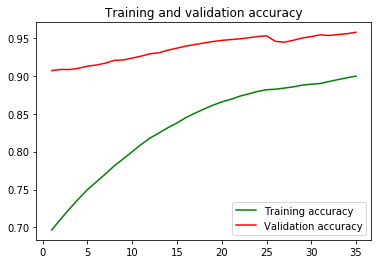

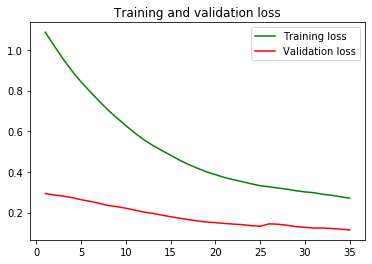

In [33]:
plot_data(history, smooth=True)

In [15]:
# Create a new validation generator for evaluation
valid_test_gen = test_datageneration.flow_from_directory(
                val_fold,
                target_size=(image_height, image_width),
                color_mode='rgb',
                batch_size=1,
                class_mode='categorical',
                shuffle=False)

Found 765 images belonging to 6 classes.


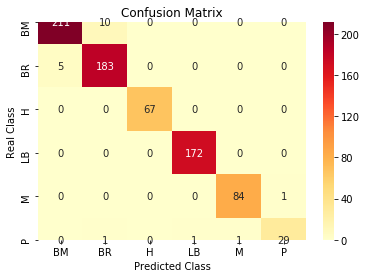

Classification Report
               precision    recall  f1-score   support

black_measles       0.98      0.95      0.97       221
    black_rot       0.94      0.97      0.96       188
      healthy       1.00      1.00      1.00        67
  leaf_blight       0.99      1.00      1.00       172
     mealybug       0.99      0.99      0.99        85
   phylloxera       0.97      0.91      0.94        32

     accuracy                           0.98       765
    macro avg       0.98      0.97      0.97       765
 weighted avg       0.98      0.98      0.98       765



In [35]:
# Load the trained model from the folder
model = load_model(filepath=os.path.join(trained_models, 'diseasepest-VGG16.h5'))

# Display confusion matrix and classification report
collect_metrics(model, generator=valid_test_gen, steps=total_valid)

### Fine-Tune Model

In [36]:
conv_base.layers

In [37]:
# Get the final convolutional block
conv_base.layers[0].name

'input_2'

In [38]:
# Fine-tune the model by unfreezing the final convolutional block

conv_base.trainable = True
trainable_logic = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    trainable_logic = True
  if trainable_logic:
    layer.trainable = True
  else:
    layer.trainable = False

In [39]:
# Compile the model and avoid overfitting by utilizing a much smaller learning rate
model.compile(optimizer=optimizers.Adam(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [40]:
# Train the model
history = model.fit(
            training_gen,
            steps_per_epoch=total_train // batch_size,
            epochs=epochs,
            validation_data=valid_gen,
            validation_steps=total_valid // batch_size,
            callbacks=[tensorboard_callback])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 102 steps, validate for 25 steps
Epoch 1/35
 89/102 [=========================>....] - ETA: 1:36 - loss: 0.2011 - acc: 0.9231

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 947s 9s/step - loss: 0.1970 - acc: 0.9238 - val_loss: 0.0721 - val_acc: 0.9760
Epoch 2/35
  1/102 [..............................] - ETA: 13:58 - loss: 0.2495 - acc: 0.9000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 962s 9s/step - loss: 0.1889 - acc: 0.9258 - val_loss: 0.0737 - val_acc: 0.9760
Epoch 3/35
  1/102 [..............................] - ETA: 14:13 - loss: 0.0826 - acc: 0.9667

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 951s 9s/step - loss: 0.1946 - acc: 0.9307 - val_loss: 0.0757 - val_acc: 0.9760
Epoch 4/35
 12/102 [==>...........................] - ETA: 11:23 - loss: 0.2080 - acc: 0.9306

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 959s 9s/step - loss: 0.1896 - acc: 0.9310 - val_loss: 0.0763 - val_acc: 0.9747
Epoch 5/35


C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 960s 9s/step - loss: 0.1713 - acc: 0.9382 - val_loss: 0.0765 - val_acc: 0.9760
Epoch 6/35
 10/102 [=>............................] - ETA: 11:39 - loss: 0.1424 - acc: 0.9467

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 38840s 381s/step - loss: 0.1655 - acc: 0.9399 - val_loss: 0.0758 - val_acc: 0.9760
Epoch 7/35
  2/102 [..............................] - ETA: 18:12 - loss: 0.1593 - acc: 0.9500

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1060s 10s/step - loss: 0.1717 - acc: 0.9369 - val_loss: 0.0754 - val_acc: 0.9773
Epoch 8/35
 45/102 [============>.................] - ETA: 8:09 - loss: 0.1631 - acc: 0.9408

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1038s 10s/step - loss: 0.1698 - acc: 0.9359 - val_loss: 0.0738 - val_acc: 0.9787
Epoch 9/35
 28/102 [=======>......................] - ETA: 9:32 - loss: 0.1826 - acc: 0.9429

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1001s 10s/step - loss: 0.1754 - acc: 0.9389 - val_loss: 0.0744 - val_acc: 0.9800
Epoch 10/35
 67/102 [==================>...........] - ETA: 4:29 - loss: 0.1582 - acc: 0.9413

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 978s 10s/step - loss: 0.1595 - acc: 0.9402 - val_loss: 0.0737 - val_acc: 0.9773
Epoch 11/35
 76/102 [=====================>........] - ETA: 3:36 - loss: 0.1538 - acc: 0.9457

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1069s 10s/step - loss: 0.1581 - acc: 0.9448 - val_loss: 0.0729 - val_acc: 0.9813
Epoch 12/35
  7/102 [=>............................] - ETA: 12:30 - loss: 0.1359 - acc: 0.9429

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1001s 10s/step - loss: 0.1532 - acc: 0.9451 - val_loss: 0.0720 - val_acc: 0.9760
Epoch 13/35
 91/102 [=========================>....] - ETA: 1:24 - loss: 0.1682 - acc: 0.9340

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 971s 10s/step - loss: 0.1726 - acc: 0.9330 - val_loss: 0.0716 - val_acc: 0.9800
Epoch 14/35
 81/102 [======================>.......] - ETA: 2:38 - loss: 0.1535 - acc: 0.9428

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 951s 9s/step - loss: 0.1528 - acc: 0.9402 - val_loss: 0.0716 - val_acc: 0.9800
Epoch 15/35
  2/102 [..............................] - ETA: 13:46 - loss: 0.2705 - acc: 0.9167

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 946s 9s/step - loss: 0.1516 - acc: 0.9396 - val_loss: 0.0718 - val_acc: 0.9760
Epoch 16/35
 57/102 [===============>..............] - ETA: 5:35 - loss: 0.1426 - acc: 0.9457

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 944s 9s/step - loss: 0.1563 - acc: 0.9419 - val_loss: 0.0713 - val_acc: 0.9787
Epoch 17/35
 12/102 [==>...........................] - ETA: 11:24 - loss: 0.1891 - acc: 0.9250

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 944s 9s/step - loss: 0.1498 - acc: 0.9412 - val_loss: 0.0709 - val_acc: 0.9773
Epoch 18/35
 41/102 [===========>..................] - ETA: 7:36 - loss: 0.1571 - acc: 0.9382

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 957s 9s/step - loss: 0.1548 - acc: 0.9366 - val_loss: 0.0716 - val_acc: 0.9747
Epoch 19/35
 33/102 [========>.....................] - ETA: 9:00 - loss: 0.1656 - acc: 0.9312

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1097s 11s/step - loss: 0.1555 - acc: 0.9386 - val_loss: 0.0719 - val_acc: 0.9773
Epoch 20/35


C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1117s 11s/step - loss: 0.1688 - acc: 0.9313 - val_loss: 0.0715 - val_acc: 0.9760
Epoch 21/35
 58/102 [================>.............] - ETA: 6:25 - loss: 0.1750 - acc: 0.9351

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1029s 10s/step - loss: 0.1570 - acc: 0.9402 - val_loss: 0.0720 - val_acc: 0.9773
Epoch 22/35
 29/102 [=======>......................] - ETA: 9:18 - loss: 0.1556 - acc: 0.9391

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1012s 10s/step - loss: 0.1630 - acc: 0.9382 - val_loss: 0.0719 - val_acc: 0.9800
Epoch 23/35
 92/102 [==========================>...] - ETA: 1:20 - loss: 0.1487 - acc: 0.9421

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1024s 10s/step - loss: 0.1465 - acc: 0.9425 - val_loss: 0.0723 - val_acc: 0.9787
Epoch 24/35
 42/102 [===========>..................] - ETA: 7:44 - loss: 0.1607 - acc: 0.9365

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 984s 10s/step - loss: 0.1526 - acc: 0.9396 - val_loss: 0.0714 - val_acc: 0.9787
Epoch 25/35
 33/102 [========>.....................] - ETA: 9:00 - loss: 0.1535 - acc: 0.9374

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 999s 10s/step - loss: 0.1505 - acc: 0.9389 - val_loss: 0.0706 - val_acc: 0.9787
Epoch 26/35
 33/102 [========>.....................] - ETA: 8:46 - loss: 0.1467 - acc: 0.9466

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 987s 10s/step - loss: 0.1462 - acc: 0.9458 - val_loss: 0.0698 - val_acc: 0.9787
Epoch 27/35


C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 998s 10s/step - loss: 0.1489 - acc: 0.9422 - val_loss: 0.0701 - val_acc: 0.9787
Epoch 28/35
 63/102 [=================>............] - ETA: 4:59 - loss: 0.1521 - acc: 0.9434

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 987s 10s/step - loss: 0.1493 - acc: 0.9422 - val_loss: 0.0700 - val_acc: 0.9787
Epoch 29/35
 85/102 [========================>.....] - ETA: 2:14 - loss: 0.1338 - acc: 0.9507

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1002s 10s/step - loss: 0.1444 - acc: 0.9461 - val_loss: 0.0704 - val_acc: 0.9787
Epoch 30/35
 53/102 [==============>...............] - ETA: 6:17 - loss: 0.1503 - acc: 0.9459

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 964s 9s/step - loss: 0.1425 - acc: 0.9465 - val_loss: 0.0704 - val_acc: 0.9800
Epoch 31/35
  8/102 [=>............................] - ETA: 13:25 - loss: 0.1376 - acc: 0.9375

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1020s 10s/step - loss: 0.1408 - acc: 0.9438 - val_loss: 0.0702 - val_acc: 0.9800
Epoch 32/35
 86/102 [========================>.....] - ETA: 2:08 - loss: 0.1355 - acc: 0.9501

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1018s 10s/step - loss: 0.1366 - acc: 0.9491 - val_loss: 0.0704 - val_acc: 0.9800
Epoch 33/35
  5/102 [>.............................] - ETA: 12:56 - loss: 0.1020 - acc: 0.9600

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 994s 10s/step - loss: 0.1380 - acc: 0.9511 - val_loss: 0.0698 - val_acc: 0.9800
Epoch 34/35


C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1033s 10s/step - loss: 0.1476 - acc: 0.9409 - val_loss: 0.0699 - val_acc: 0.9787
Epoch 35/35
 65/102 [==================>...........] - ETA: 5:00 - loss: 0.1309 - acc: 0.9529

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1036s 10s/step - loss: 0.1348 - acc: 0.9514 - val_loss: 0.0715 - val_acc: 0.9787


In [41]:
# Save the model into the pre-defined folder
model.save(os.path.join(trained_models, 'diseasepest-VGG16-ft.h5'))

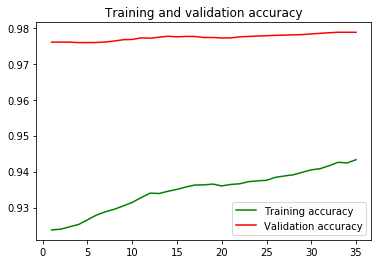

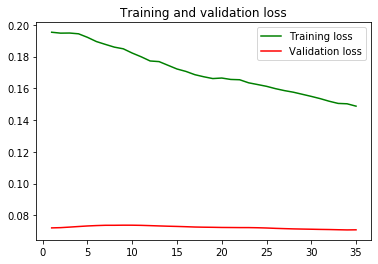

In [42]:
plot_data(history, smooth=True)

In [16]:
# Create a new validation generator for evaluation
val_test_gen = test_datageneration.flow_from_directory(
                val_fold,
                target_size=(image_height, image_width),
                color_mode='rgb',
                batch_size=1,
                class_mode='categorical',
                shuffle=False)

Found 765 images belonging to 6 classes.


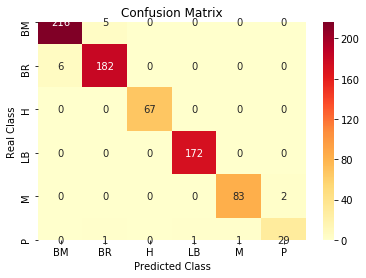

Classification Report
               precision    recall  f1-score   support

black_measles       0.97      0.98      0.98       221
    black_rot       0.97      0.97      0.97       188
      healthy       1.00      1.00      1.00        67
  leaf_blight       0.99      1.00      1.00       172
     mealybug       0.99      0.98      0.98        85
   phylloxera       0.94      0.91      0.92        32

     accuracy                           0.98       765
    macro avg       0.98      0.97      0.97       765
 weighted avg       0.98      0.98      0.98       765



In [44]:
# Load the saved model from the pre-defined folder
model = load_model(filepath=os.path.join(trained_models, 'diseasepest-VGG16-ft.h5'))

# Display confusion matrix and classification report
collect_metrics(model, generator=val_test_gen, steps=total_valid)


### Final Model Evaluation on Test Data

In [17]:
# Create a new test generator for evaluation
test_generator = test_datageneration.flow_from_directory(
                test_fold,
                target_size=(image_height, image_width),
                color_mode='rgb',
                batch_size=1,
                class_mode='categorical',
                shuffle=False)

Found 957 images belonging to 6 classes.


Instructions for updating:
Please use Model.predict, which supports generators.


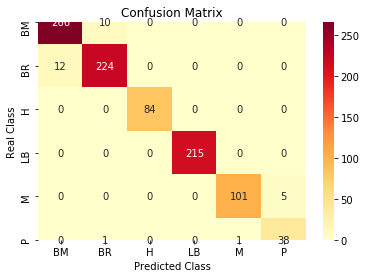

Classification Report
               precision    recall  f1-score   support

black_measles       0.96      0.96      0.96       276
    black_rot       0.95      0.95      0.95       236
      healthy       1.00      1.00      1.00        84
  leaf_blight       1.00      1.00      1.00       215
     mealybug       0.99      0.95      0.97       106
   phylloxera       0.88      0.95      0.92        40

     accuracy                           0.97       957
    macro avg       0.96      0.97      0.97       957
 weighted avg       0.97      0.97      0.97       957



In [18]:
# Load the saved model from the pre-defined folder
model = load_model(filepath=os.path.join(trained_models, 'diseasepest-VGG16-ft.h5'))


# Display confusion matrix and classification report
collect_metrics(model, generator=test_generator, steps=total_test)

In [19]:
# Look for all misclassified images 
y_pred = model.predict_generator(generator=test_generator, steps=total_test)
y_pred = np.argmax(y_pred, axis=1)
y_real = test_generator.classes

# Show indices of these misclassified images
index = np.where(np.not_equal(y_pred, y_real))
index

(array([  4,  53,  74, 100, 211, 219, 238, 246, 248, 259, 321, 330, 358,
        361, 375, 400, 401, 406, 438, 455, 475, 510, 812, 853, 864, 895,
        914, 919, 921], dtype=int64),)

In [20]:
# Display paths of misclassified images
paths = [test_generator.filepaths[i] for i in index[0]]
paths

['.\\img_data\\test\\black_measles\\black_measles1022.jpg',
 '.\\img_data\\test\\black_measles\\black_measles1227.jpg',
 '.\\img_data\\test\\black_measles\\black_measles1323.jpg',
 '.\\img_data\\test\\black_measles\\black_measles213.jpg',
 '.\\img_data\\test\\black_measles\\black_measles689.jpg',
 '.\\img_data\\test\\black_measles\\black_measles753.jpg',
 '.\\img_data\\test\\black_measles\\black_measles86.jpg',
 '.\\img_data\\test\\black_measles\\black_measles883.jpg',
 '.\\img_data\\test\\black_measles\\black_measles897.jpg',
 '.\\img_data\\test\\black_measles\\black_measles945.jpg',
 '.\\img_data\\test\\black_rot\\black_rot123.jpg',
 '.\\img_data\\test\\black_rot\\black_rot193.jpg',
 '.\\img_data\\test\\black_rot\\black_rot341.jpg',
 '.\\img_data\\test\\black_rot\\black_rot356.jpg',
 '.\\img_data\\test\\black_rot\\black_rot41.jpg',
 '.\\img_data\\test\\black_rot\\black_rot525.jpg',
 '.\\img_data\\test\\black_rot\\black_rot526.jpg',
 '.\\img_data\\test\\black_rot\\black_rot550.jpg',
 

In [ ]:
# Extract weights and bias in each layer
for layer in model.layers:
    weights = layer.get_weights()[0]
    biases = layer.get_weights()[1]

    print("learned weights =", weights)

    # Biases are similar because they are all initialized with zeros (by default).
    print("learned biases =", biases)

In [ ]:
# print all hidden layers
tf.compat.v1.disable_eager_execution()
for layer in model.layers:
    hidden_layer = layer.output
    
    print(hidden_layer)

In [ ]:
# get all nodes in each layer
for layer in model.layers:
    for node in layer._inbound_nodes:
         for i in range(len(node.inbound_layers)):
            inbound_node_index = node.node_indices
            layer.get_input_at(inbound_node_index)
            layer.get_output_at(inbound_node_index)
            layer.get_input_shape_at(inbound_node_index)
            layer.get_output_shape_at(inbound_node_index)

In [ ]:
all_nodes = [n for n in tf.get_default_graph().as_graph_def().node]
layer.get_input_at(node_index)
layer.get_output_at(node_index)
layer.get_input_shape_at(node_index)
layer.get_output_shape_at(node_index)

In [ ]:

from keras.models import Sequential
from keras import layers as l
from keras.applications.vgg16 import VGG16
from keras_sequential_ascii import keras2ascii

vgg16 = VGG16(weights=None)
keras2ascii(vgg16)

In [ ]:
from keras.models import Sequential
from keras import layers as l
from keras.applications.vgg16 import VGG16
from keras_sequential_ascii import keras2ascii

conv_base1 = VGG16(include_top=False,
                  weights='imagenet',
                  input_shape=(img_height, img_width, 3))
keras2ascii(conv_base1)